In [2]:
from __future__ import division
import pandas as pd
from collections import Counter
from itertools import chain, groupby
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
import random
import math

In [3]:
class NaiveBayesClassifier:
    
    def __init__(self, df, output_col_name, features):
        self.df = df
        self.conditional_probabilites = {}
        self.prior_probabilites = {}
        self.output = output_col_name
        self.features = features
        
    def calculate_prior_probabilites(self):
        groups = self.df.groupby(self.output).groups
        for x in groups:
            self.prior_probabilites[x] = len(groups[x])/len(df)
    
    def calculate_conditional_probabilites(self):
        for x in self.features:
            if x != self.output:
                self.conditional_probabilites[x] = self.df.groupby(self.output)[x].value_counts()/self.df.groupby(self.output)[x].count()
                
    def train(self):
        self.calculate_prior_probabilites()
        self.calculate_conditional_probabilites()
    
    def predict(self, row):
        posterior_prob = {}
        
        # Initialize the posterior probability as same as the priors
        for x in self.prior_probabilites:
            posterior_prob[x] = self.prior_probabilites[x]
        
        for label in posterior_prob:
            for x in self.features:
                if x != self.output:
                    if label in self.conditional_probabilites[x] and row[x] in self.conditional_probabilites[x].get(label):
                        posterior_prob[label] *= self.conditional_probabilites[x].get(label).get(row[x])
                    else:
                        posterior_prob[label] = 0
                        break
        return max(posterior_prob, key=posterior_prob.get)

In [4]:
class LogisticRegression:
    
    def __init__(self, X, output, w, alpha):
        self.X = X
        self.output = output
        self.alpha = alpha
        self.w = w
    
    @staticmethod
    def sigmoid_function(x):
        val = 1/(1 + np.exp(-x))
        return val
    
    @staticmethod
    def compute_regressor(w, X):
        regressor = np.dot(w, X)
        return LogisticRegression.sigmoid_function(regressor)
       
    def gradient(self, j):
        total_error = 0
        for i in xrange(len(self.output)):
            xi = self.X[i]
            xij = xi[j]
            yi = self.output[i]
            ri = LogisticRegression.compute_regressor(self.w, xi)
            if yi == -1:
                yi = 0
            diff = xij*(yi-ri)
            total_error += diff
        constant = float(self.alpha)/float(len(self.output))
        grad = constant * total_error
        return grad
    
    
    def gradient_ascent(self):
        wi = []
        for j in xrange(len(self.w)):
            grad = self.gradient(j)
            wij = self.w[j] + grad[0]
            wi.append(wij)
        return wi
    
    
    def train(self, max_iters):
        for counter in xrange(max_iters):
            wi = self.gradient_ascent()
            self.w = wi;
    
    def predict(self, x):
        posterior_prob = LogisticRegression.compute_regressor(self.w, x)
        if posterior_prob > 0.5:
            return 1
        elif posterior_prob < 0.5:
            return -1
        else:
            return random.choice([-1, 1])

In [5]:
dataPath = './DataSets/breast-cancer-wisconsin.data.txt'
columns = ['id', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'output']
features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'output']
df = pd.read_csv(dataPath, names=columns)
df = df.replace('?', np.nan)
df[['x6']] = df[['x6']].apply(pd.to_numeric)
df = df.replace(np.nan, df['x6'].mean())
df.isnull().sum()

id        0
x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
x7        0
x8        0
x9        0
output    0
dtype: int64

In [6]:
df['output'] = df['output'].apply(lambda x : 1 if x == 2 else -1)

In [7]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df[features], df['output'], 
                                                                test_size=0.33, random_state=42)
print len(df_X_train)
print len(df_y_train)

468
468


In [8]:
fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]
training_data_size = []
nb_accuracy = []

for fraction in fractions:
    df_train = df_X_train.sample(frac=fraction)
    training_data_size.append(len(df_train))
    
    misclassfication_total = 0
    avg_val = 0
    
    for counter in range(1, 6, 1):
        nbclassifier = NaiveBayesClassifier(df=df_train, output_col_name='output', features=features)
        nbclassifier.train()
        df_X_test['prediction'] = df_X_test.apply(lambda row : nbclassifier.predict(row), axis=1)
        accuracy_results = pd.crosstab(df_X_test['prediction'], df_y_test)

        misclassifcation = 0;

        if 1 in accuracy_results:
            if -1 in accuracy_results[1]:
                misclassifcation += accuracy_results[1][-1]


        if -1 in accuracy_results:
            if 1 in accuracy_results[-1]:
                misclassifcation += accuracy_results[-1][1]

        misclassfication_total += misclassifcation
    avg_val = misclassfication_total/5
    
    avg_val = 100 -((avg_val/len(df_X_test))*100)
    
    nb_accuracy.append(avg_val)
print nb_accuracy

[66.666666666666671, 66.666666666666671, 66.666666666666671, 87.012987012987011, 93.939393939393938, 96.969696969696969]


In [9]:
fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]
training_data_size = []
cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
lr_accuracy = []
for fraction in fractions:
    
    df_train = df_X_train.sample(frac=fraction)
    training_data_size.append(len(df_train))
    
    misclassfication_total = 0
    avg_val = 0
    
    for counter in range(1, 6, 1):
        w = [0, 0, 0, 0, 0, 0, 0, 0, 0]

        lr = LogisticRegression(df_train.as_matrix(columns=cols), df_train.as_matrix(columns=['output']), w, 0.1)
        lr.train(100)
        #print lr.w
        df_X_test['lprediction'] = df_X_test.apply(lambda row : lr.predict(row.as_matrix(columns=cols)), axis=1)
        accuracy_results = pd.crosstab(df_X_test['lprediction'], df_y_test)
        misclassifcation = 0;

        if 1 in accuracy_results:
            if -1 in accuracy_results[1]:
                misclassifcation += accuracy_results[1][-1]


        if -1 in accuracy_results:
            if 1 in accuracy_results[-1]:
                misclassifcation += accuracy_results[-1][1]

        misclassfication_total += misclassifcation
        
    avg_val = misclassfication_total/5
    
    avg_val = 100 -((avg_val/len(df_X_test))*100)
    
    lr_accuracy.append(avg_val)
print lr_accuracy

[70.562770562770567, 72.727272727272734, 77.056277056277054, 80.952380952380949, 82.683982683982691, 82.251082251082252]


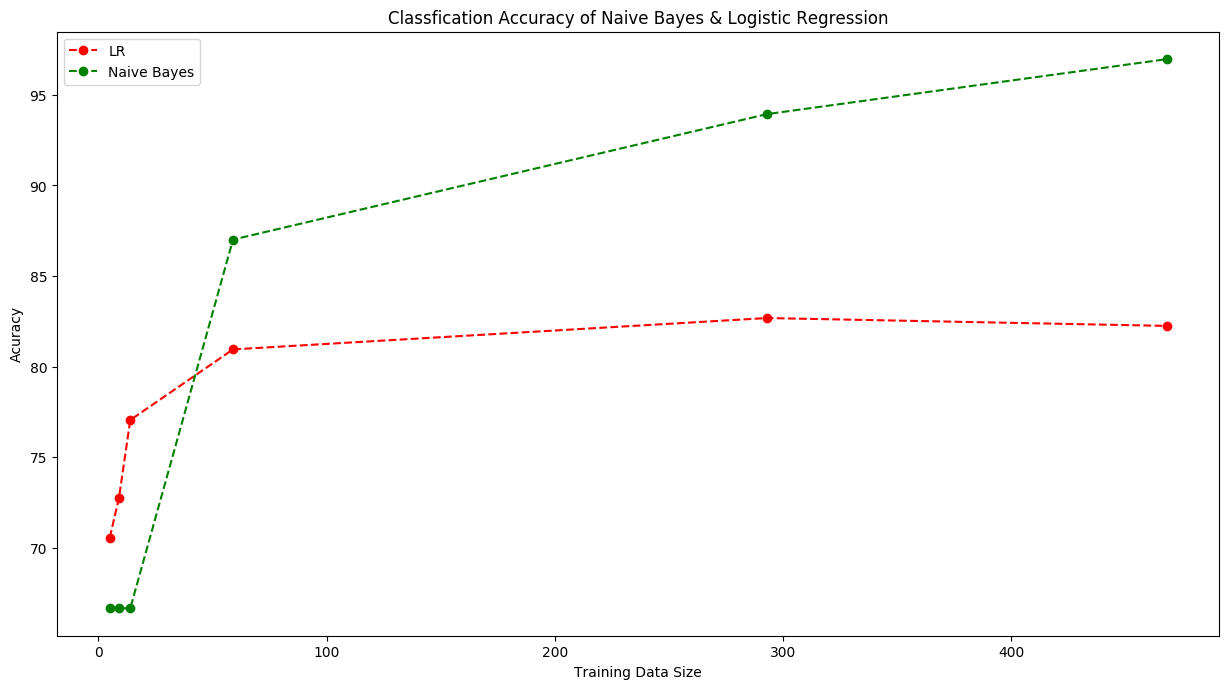

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8), dpi=100)
plt.plot(training_data_size, lr_accuracy, marker='o', linestyle='--', color='r', label='LR')
plt.plot(training_data_size, nb_accuracy, marker='o', linestyle='--', color='g', label='Naive Bayes')
plt.xlabel('Training Data Size')
plt.ylabel('Acuracy')
plt.title('Classfication Accuracy of Naive Bayes & Logistic Regression')
plt.legend()
plt.show()